<a href="https://colab.research.google.com/github/annikaaross/Homochirality-project/blob/lio's-branch/Lio_Tidied_Homochirality_v005.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homochirality Model

Hello and welcome to *Do Opposites Attract?*, the first monomer dating show. We're here to see if similarity between member(s) of a relationship matters in the strength of the bond between the individuals. Read on as we introduce you to our monomers, our polymers, and the stylish bag that they reside in. Along the way we will keep you up to date on all the drama of falling in love and breaking hearts. 

I am editing this in colab. I am aiming to see how it workd to run this back into github - I feel like I did this yesterday but i need to practice again.

## Global Parameters

Here's where we keep the rules by which our contestants must play.

In [25]:
#the bond break probbility applied to all bonds
BASE_BOND_BREAK_PROBABILITY = 1
#if a bond itself is homochiral the base bond fator is multiplied by
#this factor
HOMOCHIRAL_BREAK_FACTOR = 0.9
#this factor is incorporated for each additional neighboring homochiral bond
# becomes less and less influential as the bond gets further away
HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR = 0.3
#decreases the break probability based on the length of the polymer
LENGTH_FACTOR = 0.9

#dictionary of poisson values
poissondict={}
#used in Poisson distribution
LAMBDA=6
#################################################################
#these are the same factors as before but with on for left and  #
#one for right homochiral bonds.                                #
#used in biaseastbondbreakability method which can be choosen to#
#be used over the regular eastbondbreakability method in the    #
#self.reset_break_probability() method                          #
#################################################################
HOMOCHIRAL_BREAK_FACTOR_LEFT = 0.3
HOMOCHIRAL_BREAK_FACTOR_RIGHT = 0.9
HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR_LEFT = 0.3
HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR_RIGHT = 0.3


#These are the liklihoods that a monomer will choose to poof or bond, respectively.
#Used in the Reactables class.
POOF_CHANCE = 0.3333
BOND_PROB = 0.3333



# Shorthands #
L = True
R = False

## Imports and Helpers

First we install a package called ```jdc``` which allows us to define classes across different cells using the syntax

```
%%add_to our_class
def our_function(self, our_variable):
  print our_variable
```

The documentation on this magic function can be found at https://alexhagen.github.io/jdc/






In [26]:
!pip install jdc

Here are the imports.

In [46]:
import random
import numpy as np
import copy
from google.colab import widgets
import matplotlib.pyplot as plt
import jdc
import more_itertools
import pandas as pd
import plotly.express as px

And here are some helper functions.

In [28]:
def make_pool(n):
  """
  Return a list of n new monomers.
  """
  monomers = []
  for n in range(n):
    monomers.append(Monomer())
  return monomers


def numpy_fillna(data):
  """ Rectangularize a jagged array.

  Source: https://stackoverflow.com/a/32043366
  """
  # Get lengths of each row of data
  lens = np.array([len(i) for i in data])

  # Mask of valid places in each row
  mask = np.arange(lens.max()) < lens[:,None]

  # Setup output array and put elements from data into masked positions
  out = np.zeros(mask.shape, dtype=float)
  out[mask] = np.concatenate(data)
  return out

def eAnd(*args): # From https://stackoverflow.com/q/2770434
  return [all(tuple) for tuple in zip(*args)]

## The Monomer class

These are our Monomers. The individuals in our dating show. They are the best thing a girl can be in this worl, beautiful little fools. They know that they exist and they know what kind of monomer they are, left or right(thats handedness not political party alignment) What more can you ask for?

### Constructor

In [29]:
class Monomer:

  def __init__(self, **kwargs):
    """
    The constructor method for Monomer objects. Assigns default handedness.
    Accepts argument hand = bool with keyword.
    Considering other syntax for passing in handedness.
    """
    import random
    self._handedness = kwargs['hand'] if 'hand' in kwargs else random.choice([True,False])
    self._eastbrkprob = kwargs['brkprob'] if 'brkprob' in kwargs else -1
  
  def __repr__(self):
    return str(f"{self.get_handedness()}-monomer")


### Getters and Setters

In [30]:
%%add_to Monomer

def get_handedness(self):
  """Getter method for Monomer handedness."""
  return self._handedness

def get_eastbrkprob(self):
  """Getter method for east bond brk probability"""
  return self._eastbrkprob

def set_eastbrkprob(self, newbrk):
  """Setter method for east bond brk probability"""
  self._eastbrkprob = newbrk

def reset_eastbrkprob(self) :
  """reset east brk probability to -1 
      to be called when single monomer is broken from polymer"""
  self.set_eastbrkprob(-1)


### Polymer Compatibility

In [31]:
%%add_to Monomer

def get_chirality(self):
  """ Return an expression of handedness compatible with the Polymer notation
  of chirality (n_lefts, n_rights).
  """
  if self.get_handedness():
    return (1,0)
  else:
    return (0,1)

def get_length(self):
  """ Return 1. """
  return 1

def get_ee(self):
  """ Return the enantiomeric excess of the monomer. This value is always 1. """
  return 1

def get_signed_ee(self):
  """ Return the signed enantiomeric excess of the monomer.
  Returns 1 if left handed, -1 if right handed.
  """
  if self.get_handedness():
    return 1
  else:
    return -1

def generate_old_log(self):
  """ Return a log tuple in the format
  (length, signed ee, total # homochiral bonds)
  """
  return (self.get_length(), 
          self.get_signed_ee())
          #sum(self.get_leftrighthomochiralbonds()))

def generate_log(self):
  """ Return a log compatible with the reactables history. """
  return (self.get_handedness(),)

## The Polymer class

This is our Polymer class, aka the relationships in this dating show. They contain a list of all the monomers that are inside of them. It is kept in a specific order. They are pretty open books. They can tell us how many monomers they contain, they add new members(either monomers or whole other polymers), they can remove entire groups of members after a certain index, they can check which of their bonds are homochiral and use this to calculate probability of a certain bond breaking(the weak areas in their relationship). They can use this to then tell the producers if and where they are planning on breaking off members of they ranks. Like all good relationships, they use purely mathematics and chance to determine these heart breaking decisions. They can also tell us how many left handed monomers and how many right handed monomers they contain. 

### Constructor

In [32]:
class Polymer:
  def __init__(self, monomers = []):
    """ Constructor method for Polymer.
    In addition to setting the monomers list, also calculates all break probabilities
    of the bonds it contains using reset_break_probability.
    """
    self._monomers = monomers
    self.reset_break_probability()

  def __str__(self):
    """ str function for Polymer class. """
    return f"\nA polymer of length {self.get_length()}: {self.get_sequence()}"
  
  def __repr__(self):
    """ repr function for Polymer class. """
    return f"{self.get_sequence()}-polymer"

### Getters, Setters, and Logs

In [33]:
%%add_to Polymer


def get_monomers(self):
  """ Return list of monomers in the polymer. """
  return self._monomers


def get_length(self):
  """ Return the number of monomers in the polymer. """
  return len(self._monomers)


def get_sequence(self):
  """ Return the sequence of monomers in the polymer in a human-readable (and loggable) format. """
  sequence = []
  for monomer in self.get_monomers():
    sequence.append(monomer.get_handedness())
  return sequence


def set_monomers(self, new_monomers):
  """ Set the monomers in the polymer to new_monomers. """
  self._monomers = new_monomers


def get_chirality(self):
  """ Return the chiralities of the monomers within the polymer.

  RETURN: tuple
  (number_lefts, number_rights)
  """
  #Get the monomer handednesses
  sequence = self.get_sequence()
  #Count the number of trues
  n_true = sum(sequence)
  #The number of falses is the total minus the number of trues
  #Return that.
  return (n_true, len(sequence) - n_true)

def get_signed_ee(self):
  lefts, rights = self.get_chirality()
  return (lefts - rights) / self.get_length()

def get_ee(self):
  lefts, rights = self.get_chirality()
  return abs((lefts - rights) / self.get_length())

def get_leftrighthomochiralbonds(self):
  """
  returns  # of left and right homochiral bonds in tuple (l,r)
  """
  l=0
  r=0
  for n in range(self.get_length()):
    if (self.easthomochiralbiascheck(n) == 3):
          l+=1
    elif (self.easthomochiralbiascheck(n) == 5):
          r+=1
  tuple1=(l,r)
  return tuple1
  
def generate_old_log(self):
  """ Return a log tuple in the format
  (length, signed ee, total # homochiral bonds)
  """
  return (self.get_length(), 
          self.get_signed_ee())
          #sum(self.get_leftrighthomochiralbonds()))
  
def generate_log(self):
  """ Return a log tuple formatted simply as the list of boolean handednesses of the monomers contained
  in the polymer. Will be heavier than holding data about the polymer like in the other log format,
  but should allow access to more information and more kinds of information.
  """
  return tuple(self.get_sequence())

### Functionality methods

In [34]:
%%add_to Polymer

def append(self, other):
  """
  Adds a reactable (monomer or polymer) to the end of the Polymer.
  If the added reactable is a polymer, append() deletes it after taking its monomers.
  """
  #Check the type of thing to add
  if isinstance(other, Monomer):
    #Monomers can just be appended to the list
    self._monomers.append(other)
  elif isinstance(other, Polymer):
    #For polymers we need to extend rather than append, to avoid nested lists
    self._monomers.extend(other.get_monomers())
    #Then once the monomers are safely in their new polymer, the old one is deleted
    del other

def brkloc(self):

  #makes a list of all the indices of monomers in the polymer except 
  #for the last one
  indices = []
  for n in range(self.get_length() - 1):
    indices.append(n)
  #puts indices in random order
  random.shuffle(indices)
  #tests if each indices will break
  for index in indices:
    #gets the breakprobability for monomer at n index
    brkprob = self._monomers[n].get_eastbrkprob()
    rand = random.random()
    # checks if the random number is less than the brkprob then the index of
    #the monomer is returned from the method
    #indicating this polymer breaks at the east bond of this monomer
    if(brkprob > rand):
      return n
  return None

def removeright(self,location):
  """
  Removes all monomers to the right (east) of a given index
  """
  #creates a list of monomers in the polymer to the left, and including,
  #the monomer at the location(index) provided
  newList = self._monomers[0:location+1]

  #makes a list of the monoers to the rightof the monomer at the 
  #index provided
  removed = self._monomers[location+1:]

  #sets the polymers monomers to newList(the monomers to the left
  #of  and the index provided)
  self.set_monomers(newList)
  #print("after breaking ractable is:",self)
  #print("after breaking removed is:",removed)

  #returns the monomers that were removed, everything the right
  #of the index provided
  return removed

### Homochirality handling

In [35]:
%%add_to Polymer

def easthomochiralcheck(self,numbermonomer):
  """
  Takes the index of a monomer within the Polymer and returns whether its east bond is homochiral.
  """
  #First check that the index isn't out of bounds 
  if (0 > numbermonomer or numbermonomer >= self.get_length()-1):
    #Should this raise an IndexError instead of returning False?
    return False
  #get the handedness of this monomer and its east neighbor, and return whether or not they're equal (bool)
  return self._monomers[numbermonomer].get_handedness() == self._monomers[numbermonomer+1].get_handedness()

def easthomochiralbiascheck (self, numbermonomer):
  """ this method can be used in place of the east homochiral check method
  returns false if not homochiral, 3 if homochiral left, 5 if homochiral right"""
    #First check that the index isn't out of bounds 
  if (0 > numbermonomer or numbermonomer >= self.get_length()-1):
    #Should this raise an IndexError instead of returning False?
    return False
  #get the handedness of this monomer and its east neighbor, and return whether or not they're equal (bool)
  if (self._monomers[numbermonomer].get_handedness() == self._monomers[numbermonomer+1].get_handedness()):
    if self._monomers[numbermonomer].get_handedness():
      return 3
    elif not self._monomers[numbermonomer].get_handedness():
      return 5
      


def eastbondbreakprobability(self,numbermonomer):
  """
  Takes the index of a monomer within the Polymer
  Returns the probability that the monomer's east bond will break
  returns -3 if the monomer has no east bond
  """
  ##############################
  #Override to return an equal break chance for every bond in the polymer
  #Simply comment out this line to get the regular function
  #return (0.3)
  ##############################
  #Initialize vars
  brk = -3
  length = self.get_length()
  #First check if the monomer is the last one in the polymer
  if (numbermonomer >= length-1):
    #If so, it doesn't have an east bond to break, so the probability is 0
    return brk
  #With that out of the way, we set brk to the base probability of breaking a bond
  #set to base bondbreak  multiplied by length factor to the power of 
  #the length of the polymer(breaking becomes less likely as the
  #polymer becomes longer)
  brk = BASE_BOND_BREAK_PROBABILITY * (LENGTH_FACTOR**self.get_length())

  #check if the east bond is homochiral
  if (self.easthomochiralcheck(numbermonomer)):
    brk *= HOMOCHIRAL_BREAK_FACTOR
    j = numbermonomer+1

    #going right to check for neighboring homochirality
    while(self.easthomochiralcheck(j)):
      brk *= 1 - (HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR**abs(j - numbermonomer))
      j += 1

    #going left to check for neighboring homochirality
    j=numbermonomer-1
    while(self.easthomochiralcheck(j)):
      brk *= 1-(HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR**abs(numbermonomer - j))
      j -= 1
  return brk

def biaseastbondbreakprobability(self,numbermonomer):
  """
  ***left-right sensitivity****
  Takes the index of a monomer within the Polymer
  Returns the probability that the monomer's east bond will break
  returns -3 if the monomer has no east bond
  """
  ##############################
  #Override to return an equal break chance for every bond in the polymer
  #Simply comment out this line to get the regular function
  #return (0.3)
  ##############################
  #Initialize vars
  brk = -3
  length = self.get_length()
  #First check if the monomer is the last one in the polymer
  if (numbermonomer >= length-1):
    #If so, it doesn't have an east bond to break, so the probability is 0
    return brk
  #With that out of the way, we set brk to the base probability of breaking a bond
  #set to base bondbreak  multiplied by length factor to the power of 
  #the length of the polymer(breaking becomes less likely as the
  #polymer becomes longer)
  brk = BASE_BOND_BREAK_PROBABILITY * (LENGTH_FACTOR**self.get_length())

  #Check if the east bond is not homorchiral
  if (not self.easthomochiralbiascheck(numbermonomer)):
    return brk

  #check if the east bond is homochiral left
  if (self.easthomochiralbiascheck(numbermonomer)== 3):
    brk *= HOMOCHIRAL_BREAK_FACTOR_LEFT
    j = numbermonomer+1

    #going right to check for neighboring lefts
    while(self.easthomochiralcheck(j)):
      brk *= 1 - (HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR_LEFT**abs(j - numbermonomer))
      j += 1

    #going left to check for neighboring lefts
    j=numbermonomer-1
    while(self.easthomochiralcheck(j)):
      brk *= 1-(HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR_LEFT**abs(numbermonomer - j))
      j -= 1

  #checks if bond is homochiral right
  elif (self.easthomochiralbiascheck(numbermonomer) == 5):
    brk *= HOMOCHIRAL_BREAK_FACTOR_RIGHT
    j = numbermonomer+1

    #going right checking for neighboring rights
    while(self.easthomochiralcheck(j)):
      brk *= 1 - (HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR_RIGHT**abs(j - numbermonomer))
      j += 1

    #going left checking for neighboring lefts
    j=numbermonomer-1
    while(self.easthomochiralcheck(j)):
      brk *= 1-(HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR_RIGHT**abs(numbermonomer - j))
      j -= 1
  return brk

def poissonbreakprobability(self,numbermonomer):
  """
  Takes the index of a monomer within the Polymer
  Returns the probability that the monomer's east bond will break
  based on Poisson distribution
  returns -3 if the monomer has no east bond
  """
  #Initialize brk
  brk = -3
  length = self.get_length()
  #First check if the monomer is the last one in the polymer
  if (numbermonomer >= length-1):
    #If so, it doesn't have an east bond to break, so the probability is 0
    return brk
  #With that out of the way, we set brk to the base probability of breaking a bond
  #set to base bondbreak  multiplied by length factor to the power of 
  #the length of the polymer(breaking becomes less likely as the
  #polymer becomes longer)
  brk = BASE_BOND_BREAK_PROBABILITY * (LENGTH_FACTOR**self.get_length())
  #keeps track of the number of homochiral bonds
  poisson=0 
  #check if the east bond is homochiral
  if (self.easthomochiralcheck(numbermonomer)):
    poisson+=1
    brk *= 1-self.poissonequation(poisson)
    j = numbermonomer+1
    #going right to check for neighboring homochirality
    while(self.easthomochiralcheck(j)):
      poisson+=1
      brk *= 1 - (self.poissonequation(poisson))
      j += 1
    #going left to check for neighboring homochirality
    j=numbermonomer-1
    while(self.easthomochiralcheck(j)):
      poisson+=1
      brk *= 1-(self.poissonequation(poisson))
      j -= 1
  return brk

def poissonequation(self,k):
  #checks if value has already been calulated
  if (k not in poissondict):
    #calculates
    p= np.exp(-LAMBDA)*((LAMBDA**k)/(np.math.factorial(k)))
    #adds to dictionary
    poissondict[k]=p
  return poissondict[k]



def reset_break_probability(self):
  """ recalculates break probabilities for all monomers in polymer 
    can be altered to incorporate left right homochiral sensitivity"""
  #if the polymer is of length one(meaning it is about to be deleted
  #and simply recorded as a monomer) it sets its monomers 
  #brk probability to =-1
  if self.get_length() == 1 :
    self._monomers[0].set_eastbrkprob(-1)
  #otherwise goes through indices and recalcultes break prob
  else:
    for n in range(self.get_length()):
      ####################################################################
      #LEFT RIGHT SENSITIVITY CHOICE
      #comment out biaseastbondbreak to get no left/right sensitivity.   #
      #comment out eastbonbreakprobability to get left/right sensirtivity#
      ####################################################################
      #self._monomers[n].set_eastbrkprob(self.biaseastbondbreakprobability(n))
      self._monomers[n].set_eastbrkprob(self.eastbondbreakprobability(n))
      #calculates poisson brk probabilities with poisson distribution
      #self._monomers[n].set_eastbrkprob(self.poissonbreakprobability(n))
  

## The Reactables class

This is the Reactables class aka the stylish little bag we keep our contestants in. As all good dating shows, we define our members by the relationship they are in. So a single monomer will be addd to the bag alone, but a monomer in a polymer will not be. Rather each polymer will be recorded once. Its like if you have charlie, ben, and jack. Jack and Ben are in a relationship so they are jointly called Jen. If these three were in the reactable bag they would be recognized as two things, charlie and Jen(Ben+JAck). The reactable class is the heart and center of our game- I mean dating- show. Its here we ask all the members just the right questions to get them falling in love and breaking hearts, and then we are curteous enough to do all the splitting and merging for them. 

### Constructor

In [36]:
class Reactables:

  def __init__(self, reactables = []):
    """
    Constructor class for Reactables object
    Accepts list of reactables or defaults to empty list
    Reactables functions as a bin for reactable objects monomer and polymer
    Methods consist mostly of list handling
    """
    self._reactables = reactables

    #The reactables bag also handles remembering its history
    self._history = []
    self._leftrighthistory = []
    self._lookup = {}
    self._hist_stats = pd.DataFrame()

    


  def __str__(self):
    """
    str method for Reactables class
    """
    return str(self.get_reactables())

### Getters and Setters

In [37]:
%%add_to Reactables

#################
#GETTERS/SETTERS#
#################

def get_reactables(self):
  """
  Getter method for reactables in Reactables
  Returns a list of the objects currently in the Reactables bag
  """
  return self._reactables

def get_history(self):
  """ Return the history of the reactables bag.
  """
  return self._history

def get_leftrighthistory(self):
  return self._leftrighthistory

def get_count(self):
  """
  Getter method for Reactables class
  Returns the number of objects in the Reactables bag
  """
  return len(self.get_reactables()) 


def set_reactables(self, new_list):
  """
  Setter method for the Reactables class
  Sets the reactables bag to a new list
  Used mostly as a helper function in bonding
  """
  self._reactables = new_list


def get_bond_chance(self, reactable1, reactable2):
  """
  Returns the probability that two given reactables in the reactables bag will bond
  """
  return BOND_PROB

def get_free_monomers(self):
  return [r for r in self.get_reactables() if isinstance(r, Monomer)]

def get_polymers(self):
  return [r for r in self.get_reactables() if isinstance(r, Polymer)]

def get_bound_monomers(self):
  bound = []
  for p in self.get_polymers():
    bound.extend(p.get_monomers())
  return bound

def record_leftrighthomochiral(self):
  """returns the number of left and right homochiral bonds, (left,right)"""
  l=0
  r=0
  for polymer in self.get_polymers() :
    tuple1=polymer.get_leftrighthomochiralbonds()
    l += tuple1[0]
    r += tuple1[1]
  tuple2=(l,r)
  self._leftrighthistory.append(tuple2)
  return tuple2

def get_stats(self):
  return self._hist_stats

def set_hist_stats(self,df):
  self._hist_stats = df

def get_lookup(self):
  return self._lookup

def add_stat_lookup(self, key, value):
  self._lookup[key] = value

### Functionality methods

#### Top level functionality

In [38]:
%%add_to Reactables

def refill(self, pool_size):
  #Do we have less than the required number of things in the pool?
  dearth = pool_size - self.get_count()
  #If so,
  if dearth > 0:
    new = []
    #Make as many monomers as we need to get back up to the riquired amount
    for n in range(dearth):
      new.append(Monomer())
    #And add them to the reactables bag
    self.add(new)

def randomize_reactables(self):
  """
  Randomizes the order of the reactables list
  """
  #Get the current reactables
  reactables = self.get_reactables()
  #Shuffle them
  random.shuffle(reactables)
  #And reset the reactables list to the new sorted list
  self.set_reactables(reactables)

def do_the_thing(self):
  """Handle a single iteration of the reactables.

  """
  #We keep track of bonding by storing the most recent reactable to choose to bond as the 'bachelor.'
  bachelor = None
  #We need a copy of the reactables because indices will change as soon as we start doing stuff
  reactables = copy.copy(self.get_reactables())
  #Iterate through each reactable
  for item in reactables:
    #Roll a random number in (0,1) to compare against our probabilities
    roll = random.random()
    #If our reactable is a monomer...
    if isinstance(item, Monomer):
      #We get our breaking and bonding chances (parameters now, may become functions later?)
      brk = POOF_CHANCE
      bond = BOND_PROB
      #If we roll to break the monomer
      if 0 < roll <= brk:
        #Just delete it
        del item
      #If we roll to bond the monomer
      elif brk < roll <= brk+bond:
        #Check if there's a reactable waiting to bond
        if bachelor == None:
          #If not, make this monomer the bachelor. Someone will come along to bond later.
          bachelor = item
        else:
          #If there is someone waiting, bond them together and reset the bachelor chair to empty.
          self.bond_pair(bachelor, item)
          bachelor = None
      else:
        continue
    #If the reactable is a polymer instead...
    elif isinstance(item, Polymer):
      #Choose whether the polymer will break or bond. It's 50-50 right now.
      if roll >= 0.5:
        #This is the same bonding logic as for the monomer. It's not in a helper function because it needs to be able to access bachelor.
        if bachelor == None:
          bachelor = item
        else:
          self.bond_pair(bachelor, item)
          bachelor = None
      #Here's what happens if the polymer is chosen to check breaking
      else:
        #It finds its break location
        break_spot = item.brkloc()
        #Which might turn out to be nowhere.
        if break_spot != None:
          #If somewhere does break, call break_polymer to handle the breaking
          self.break_polymer(item,break_spot)
    else:
      #You never know what might end up in your reactables bag
      raise ValueError("This thing is neither a monomer or a polymer. What?!")

def iterate(self,size):
  """
  Handles full sequence of iteration
  """
  self.randomize_reactables()
  self.do_the_thing()
  self.log()
  self.record_leftrighthomochiral()
  self.refill(size)

#### Functionality helpers

In [39]:
%%add_to Reactables


def add(self, new_reactables):
  """
  Adds a list of reactables to the reactables bag
  Built on extend(); argument must be iterable
  """
  #print("list of new Reactbles", new_reactables)
  #print("list of get Reactables:",self.get_reactables())
  self.get_reactables().extend(new_reactables)
  #print("reactables list is now",self.get_reactables())


def subtract(self, removables):
  """
  Removes a list of reactables from the reactables bag
  Built on list comprehension; argument must be iterable
  """
  self.set_reactables([reactable for reactable in self.get_reactables() if not (reactable in removables)])


def bond_pair(self, west, east):
  """
  Accepts two reactables from the bag
  Bonds them together, handling deletion of any emptied polymer
  """
  #Take your two reactables and check if the west one is a monomer or a polymer 
  if isinstance(west, Polymer):
    #If it's a polymer, all you've got to do is append the east item and then take it out of the bag
    west.append(east)
    self.subtract([east])
    #recalculate the breakprobabilities of the bonds in polymer
    west.reset_break_probability()
  if isinstance(west, Monomer):
    #If west friend is a Monomer, then make a new polymer containing west
    newpoly = Polymer([west])
    #Add the east things to it
    newpoly.append(east)
    #Remove both the west monomer and the east thing
    self.subtract([east])
    self.subtract([west])
    #And put the new polymer into the reactables bag
    self.add([newpoly])
    #recalculates break probability
    newpoly.reset_break_probability()


def break_polymer(self, polymer, brk_location):
  #breaks polymer at given location and creates a new polymer of the 
  #monomers removed
  #when polymer is made-breakprobabilities are calculated
  newPolymer = Polymer(polymer.removeright(n))
  polys = [newPolymer, polymer]
  #resets break probabilities in polymer
  polymer.reset_break_probability()
  #goes throught the two new polymers
  for poly in polys:
    #checks if they are of length 1
    if poly.get_length() <= 1:
      #adds them to reactable as a single monomer
      self.add(poly.get_monomers())
      #subtracts polymer from reactable list
      self.subtract([poly])
      del poly
    #checks if the polymer is not in the reactables list
    elif (poly not in self.get_reactables()):
      #add polymer to reactable list
      self.add([poly])
    



### Current state data methods

In [40]:
%%add_to Reactables

# def get_overall_chirality(self):
#   """ Return the total quantity of left- and right-handed monomers in the reactable
#     pool, including monomers within polymers.

#   RETURN tuple
#   (Left-handed_quantity, Right-handed_quantity)
#   """
#   left_count = 0
#   right_count = 0
#   for reactable in self.get_reactables():
#     if isinstance(reactable, Monomer):
#       if reactable.get_handedness():
#         left_count += 1
#       else:
#         right_count += 1
#     elif isinstance(reactable, Polymer):
#       l, r = reactable.get_chirality()
#       left_count += l
#       right_count += r
#     else:
#       print(f"{reactable}, which is a {type(reactable)}")
#       raise ValueError
#   return (left_count, right_count)

# def get_polymer_chirality(self):
#   """ Return the total quantity of left- and right-handed monomers in the polymers
#   within the reactable pool.

#   RETURN tuple
#   (Left-handed_quantity, Right-handed_quantity)
#   """
#   left_count = 0
#   right_count = 0
#   for reactable in self.get_reactables():
#     if isinstance(reactable, Polymer):
#       l, r = reactable.get_chirality()
#       left_count += l
#       right_count += r
#   return (left_count, right_count)

# def get_free_proportion(self):
#   """Return the proportion of free monomers to total population"""
#   return len(self.get_free_monomers())/self.unit_count()

# def unit_count(self):
#   """return the total number of monomers in the bag, both free and bound"""
#   bound = 0
#   for p in self.get_polymers():
#     bound += p.get_length()
#   return len(self.get_free_monomers()) + bound

# def get_polymer_ee(self):
#   ee = []
#   for polymer in self.get_polymers():
#     ee.append(polymer.get_signed_ee())
#   return ee

# def avg_ee_by_length(self):
#   """ Return a list containing the enantiomeric excess of all reactables sorted by size.
#   That is:
#   [(ee of monomers),(ee of 2-mers),(ee of 3-mers) etc]
#   """
#   output = []
#   for n in range(1,self.max_length()+1):
#     group = self.get_reactables_by_length(n)
#     ees = []
#     # print(f"For length {n} I got {len(group)} reactables.")
#     if len(group) > 0:
#       # eestr = ""
#       for r in group:
#         ees.append(r.get_ee())
#         # eestr += f", {r.get_ee()}"
#       output.append(np.mean(ees))
#       # print(f"The ee's of this length were {eestr}.\nThe average ee was {np.mean(ees)}.")
#     else:
#       output.append(0)
#   return output

# def get_reactables_by_length(self,length):
#   if length <= 1:
#     #return the monomers
#     return self.get_free_monomers()
#   else:
#     return [p for p in self.get_polymers() if p.get_length() == length]

# def max_length(self):
#   """ Return the length of the longest polymer in the reactables bag.
#   """
#   length = 0
#   for p in self.get_polymers():
#     if p.get_length() > length:
#       length = p.get_length()
#   return length



### History handling methods

In [41]:
%%add_to Reactables


def log(self):
  """ Translate current reactables into a loggable list of tuples.
  This log keeps the full sequences of the polymers without digesting the data, 
  so it should be more flexible as we more forward with pulling new information
  out of this simulation. 
  There is one major piece of information lost, however, which is the identities
  of the individual polymers and monomers. """
  log = []
  for r in self.get_reactables():
    log.append(r.generate_log())
  (self._history).append(log)

def parse_history(self):
    """ Create an array of plottable information from the history log. """

    # Column labels for History Handling #
    Type = "Type"                   # Monomer or polymer
    Length = "Length"               # How many monomers in the thing
    nLefts = "#Lefts"               # How many left monomers in the thing
    nRights = "#Rights"             # How many right monomers in the thing
    Sequence = "Sequence"           # The string sequence of the thing
    nLhomo = "#LeftHomochiral"      # The number of left homochiral bonds in the polymer
    nRhomo = "#RightHomochiral"     # The number of right homochiral bonds in the polymer
    nHomo = "#Homochiral"           # The overall number of homochiral bonds in the polymer
    sEE = "Signed ee"               # The signed enantiomeric excess of the polymer (+ if more True)
    pcHomo = "%Homochirality"       # The proportion of bonds in the polymer that are homochiral
    pcLhomo = "%LeftHomochirality"  # The proportion of bonds in the polymer that are left homochiral
    pcRhomo = "%RightHomochirality" # The proportion of bonds in the polymer that are right homochiral
    Iter = "Iteration"              # The iteration number at which the item is found

    
    history = self.get_history()
    individual_stats = pd.DataFrame()
    for n in range(len(history)):
        iteration = history[n]
        for item in iteration:
            # Translate
            sequence = self.standard_form(item)

            if len(item) == 1: # It's a monomer
                #Is it in the lookup table?
                if sequence not in self.get_lookup():
                    # Get the info
                    lr = self.count_LR(item)
                    # And put it in the lookup table
                    self.add_stat_lookup(sequence, {Type: 'Monomer', 
                                                    Length:1, 
                                                    nLefts:lr[0], 
                                                    nRights:lr[1],
                                                    Sequence:sequence})
                # Now that the data is searchable...
                # Log it  
                new_log = self.get_lookup().get(sequence)
                new_log[Iter]=n
                individual_stats = individual_stats.append(new_log, ignore_index=True)

            elif len(item) > 1: # It's a polymer
                #Is it in the lookup table?
                if sequence not in self.get_lookup():
                    # Get basic info
                    length = len(item)
                    lr = self.count_LR(item)
                    bonds = self.homochiral_bond_counts(item)
                    total_homos = bonds[0]+bonds[1]
                    signed_ee = (lr[0]-lr[1])/(lr[0]+lr[1])
                    homochirality = total_homos/(length-1)
                    lhomochirality = bonds[0]/(length-1)
                    rhomochirality = bonds[1]/(length-1)
                    # And put it in the lookup table
                    self.add_stat_lookup(sequence, {Type: 'Polymer', 
                                                    Length: length, 
                                                    nLefts:lr[0], 
                                                    nRights:lr[1],
                                                    nLhomo:bonds[0],
                                                    nRhomo:bonds[1],
                                                    nHomo:total_homos,
                                                    sEE:signed_ee,
                                                    pcHomo:homochirality,
                                                    pcLhomo:lhomochirality,
                                                    pcRhomo:rhomochirality,
                                                    Sequence:sequence})
                # Now that the data is searchable...
                # Log it
                new_log = self.get_lookup().get(sequence)
                new_log[Iter]=n
                individual_stats = individual_stats.append(new_log, ignore_index=True)
                
            else:
                raise ValueError("There's something with length 0 in your history.")
    self.set_hist_stats(individual_stats)










#### Low level info functions

In [42]:
%%add_to Reactables

## New ones ##

  
# Functions for getting the info we want to log
    
# Number of right and left monomers in a polymer (works on monomers too)


def count_LR(self, log):
    """ Return (n_Lefts, n_Rights) """
    if L and not R:
        return (sum(log), len(log)-sum(log))
    elif R and not L:
        return (len(log)-sum(log), sum(log))
    else:
        raise ValueError("Your L's and R's are screwed up somehow.")
    


# HOMOCHIRALITY SEQUENCES #

def homochirality_sequence(self, log):
  """ Return a boolean list of bonds within a given logged polymer, True if the bond is
      homochiral. """
  return [i[0]==i[1] for i in list(more_itertools.pairwise(log))]

def _is_L_True(self, log):
    return log[:-1]


def T_homochirality_sequence(self,h_seq,L_seq):
    """ Return a boolean list of bonds within a polymer, true if the bond is 
    a homochiral bond between two True monomers. Parameters are the outputs of 
    homochirality_sequence() and _is_L_True(). """
    return eAnd(h_seq,L_seq)

# HOMOCHIRAL BOND COUNTS #
    

def homochiral_bond_counts(self,log):
    """ Return (number of left homochiral bonds, number of right homochiral bonds) """
    homo = self.homochirality_sequence(log)
    west_true = log[:-1]
    true_homochiral = eAnd(homo,west_true)
    west_false = [not m for m in west_true]
    false_homochiral = eAnd(homo,west_false)
    if L and not R:
        return (sum(true_homochiral), sum(false_homochiral))
    elif R and not L: 
        return (sum(false_homochiral), sum(true_homochiral))
    else:
        raise ValueError("Your L's and R's are screwed up somehow.")


def get_polymer_chain_lengths(self,polylog):
  """ Return the lengths of the homochiral chains in a given polymer log. """
  count = 1
  lengths = [] 
  for n in range(1,len(polylog)):
    if polylog[n] == polylog[n-1]:
      count += 1
    else:
      lengths.append(count)
      count = 1
  lengths.append(count)
  return lengths
    

def standard_form(self,poly):
  if len(poly) == 0:
    return ''
  return ''.join(['L' if m else 'R' for m in poly])
    



## Old ones ##



def hist_get_polymer_homochirality_of_bonds(self,polylog):
  """ Return a boolean list of bonds within a given logged polymer, True if the bond is
      homochiral. """
  return [i[0]==i[1] for i in list(more_itertools.pairwise(polylog))]

def hist_get_polymer_ee(self,polylog):
  """ Return the (signed) enantiomeric excess of a logged polymer. """
  length = len(polylog)
  n_True = sum(polylog)
  n_False = length - n_True
  return (n_True - n_False) / length

def hist_get_polymers(self,iteration):
  """ Return a list of the polymer logs in an iteration. This is just the iteration
  but without the monomers. """
  return [r for r in iteration if len(r) > 1]

def hist_count_longest_homochiral_chain(self,polylog):
  """ Return the length of the longest homochiral chain given the log of a polymer. """
  previous = None
  count = 1
  longest = 1
  for monomer in polylog:
    if monomer == previous:
      count += 1
    else:
      longest = max(count, longest)
      count = 1
    previous = monomer
  longest = max(count, longest)
  return longest

def hist_get_polymer_chain_lengths(self,polylog):
  """ Return the lengths of the homochiral chains in a given polymer log. """
  count = 1
  lengths = [] 
  for n in range(1,len(polylog)):
    if polylog[n] == polylog[n-1]:
      count += 1
    else:
      lengths.append(count)
      count = 1
  lengths.append(count)
  return lengths

def hist_get_iteration_chain_lengths(self,iteration):
  """ Return the lengths of all the homochiral chains in polymers in a given iteration. """
  polymers = self.hist_get_polymers(iteration)
  chain_lengths = []
  for polymer in polymers:
    chain_lengths.extend(self.hist_get_polymer_chain_lengths(polymer))
  return chain_lengths

def hist_get_bond_status(self,polylog):
  """ Iterate through the monomers in polylog ONCE to get number of left homochiral
  and right homochiral bonds, as well as chain lengths if at all possible. """
  for m in polylog:
    pass


### Plotting methods

In [43]:
%%add_to Reactables

def visualize_parameters(self,stamp=""):
  fig,ax = plt.subplots()

  parameters = ['POOF_CHANCE','BOND_PROB','BASE_BOND_BREAK_PROBABILITY',
                'HOMOCHIRAL_BREAK_FACTOR','HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR',
                'LENGTH_FACTOR','HOMOCHIRAL_BREAK_FACTOR_LEFT',
                'HOMOCHIRAL_BREAK_FACTOR_RIGHT',
                'HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR_LEFT',
                'HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR_RIGHT']
  values = [POOF_CHANCE,BOND_PROB,BASE_BOND_BREAK_PROBABILITY,
            HOMOCHIRAL_BREAK_FACTOR,HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR,
            LENGTH_FACTOR,HOMOCHIRAL_BREAK_FACTOR_LEFT,
            HOMOCHIRAL_BREAK_FACTOR_RIGHT,
            HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR_LEFT,
            HOMOCHIRAL_NEIGHBOR_IMPROV_FACTOR_RIGHT]

  ypos = np.arange(len(parameters))

  ax.barh(ypos, values, align='center')
  ax.set_yticks(ypos)
  ax.set_yticklabels(parameters)
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel('Value')
  ax.set_title(f"{stamp}Parameter values")



def plot_signed_ee_spread(self,cmap='bone',stamp=""):
  #First make the polymerspread thingy
  poly_ee_hist = []
  for iteration in self.get_history():
    polys = [log for log in iteration if not isinstance(log,bool)]
    polydata = [log for log in polys if len(log) > 1] # All the polymers (not monomers) in the iteration
    poly_ees = [self.hist_get_polymer_ee(poly) for poly in polydata] # the EE of each polymer in the iteration
    poly_ee_hist.append(poly_ees) # Put the EE list in our plottable structure
  #Now we can make the plot
  fig,ax = plt.subplots()
  ys = []
  xs = []
  for n in range(len(poly_ee_hist)):
    y = poly_ee_hist[n]
    x = [n] * len(y)
    ys.extend(y)
    xs.extend(x)
  ax.hexbin(xs,ys,cmap=cmap)
  ax.set_title(f"{stamp}polymer spread")
  ax.set_xlabel("iteraions")
  ax.set_ylabel("ee")

def plot_ee_heatmap(self,cmap='bone',stamp=""):
  #Need to figure out how to get ees_by_length from history
  ees_by_length = []
  for iteration in self.get_history():
    ee_data = []
    #get the polymers
    polys = [log for log in iteration if not isinstance(log,bool)]
    #get the length of the longest polymer
    lengths = [len(log) for log in polys]
    try:
      biggest = max(lengths)
    except:
      biggest = 0
    for n in range(1,biggest+1):
      ees = [abs(self.hist_get_polymer_ee(log)) for log in polys if len(log) == n]
      if len(ees) > 0:
        ee_data.append(np.mean(ees))
      else:
        ee_data.append(0)
    ees_by_length.append(ee_data)
  #Need to make a new ee array with rectangular dimensions
  ee = numpy_fillna(ees_by_length)
  fig,ax = plt.subplots(dpi=150)
  im = ax.imshow(ee,cmap=cmap)
  ax.set_title(f"{stamp}ee of polymers by length through iterations")
  ax.set_xlabel("polymer lengths")
  ax.set_ylabel("iterations")
  fig.tight_layout()
  plt.show()

def plot_leftrighthomochirality(self):
  plt.figure()
  l=np.zeros((ITERATIONS+1))
  r=np.zeros((ITERATIONS+1))
  x= np.arange(ITERATIONS+1)
  i=1
  for iteration in self.get_leftrighthistory():
    l[i] = iteration[0]
    r[i] = iteration[1]
    i+= 1
  plt.plot(x,l,label="left homochiral")
  plt.plot(x,r,label="right homochiral")
  plt.ylabel("Number of bonds")
  plt.xlabel("Iterations")
  plt.title("Left right homochiral bonds when LEFT="+str(HOMOCHIRAL_BREAK_FACTOR_LEFT) +  "and right=" + str(HOMOCHIRAL_BREAK_FACTOR_RIGHT))
  plt.legend()
  plt.show()

def plot_homochiral_chain_lengths(self):
  """ Plot a chart of the mean length of homochiral chains present at each iteration.
  The plot generated will attempt to summarize the mean lengths of homochiral
  chains within polymers across iterations. It will also attempt to visualize the 
  varience with continuous lines plotting the standard deviation around that mean.
  
  The x axis of the resulting plot is iterations, and the y axis is length of 
  the homochiral chains. Both of these are discrete categories, but the plot will
  treat iterations as continuous to improve readability for large n.
  """
  # Get the history and read it 
  history = self.get_history()
  means = []
  stdevs= []
  maxes = []
  for iteration in history:
    # Get the chain lengths in that iteration
    iter_data = self.hist_get_iteration_chain_lengths(iteration)
    means.append(np.mean(iter_data))
    stdevs.append(np.std(iter_data))
    maxes.append(max(iter_data))
  # Plot those data
  fig,ax = plt.subplots()
  ax.fill_between(np.arange(0,len(means)), [m + s for m, s in zip(means, stdevs)],[m - s for m, s in zip(means, stdevs)], alpha=0.2, label = "Means +- one standard deviation")
  ax.plot(means, 'k-', label = "Mean homochiral chain length")
  ax.plot(maxes, 'b.', label = "Max homochiral chain length")
  ax.set_xlabel("Iteration")
  ax.set_ylabel("Homochiral chain length")
  ax.legend()

def plot_homochirality_vs_length(self):
  """ Take all the polymers that ever existed in history and plot them on a
  scatter plot of length vs homochirality. Homochirality is the percent of their
  bonds that are homochiral. """
  #Get the history
  history = self.get_history()
  #Get the polymers
  x = []
  y = []
  for i in history:
    for p in self.hist_get_polymers(i):
      homochirality = sum(self.hist_get_polymer_homochirality_of_bonds(p))/len(p)
      x.append(len(p))
      y.append(homochirality)
  fig,ax = plt.subplots()
  ax.scatter(x,y)
  ax.set_xlabel("Polymer lengths")
  ax.set_ylabel("Homochirality")
        


    


  


## Test program

Running.............|
####################
Done.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

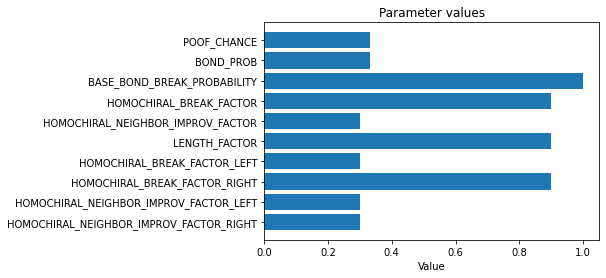

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

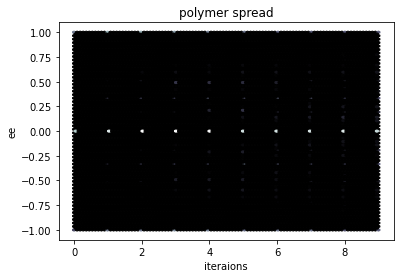

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

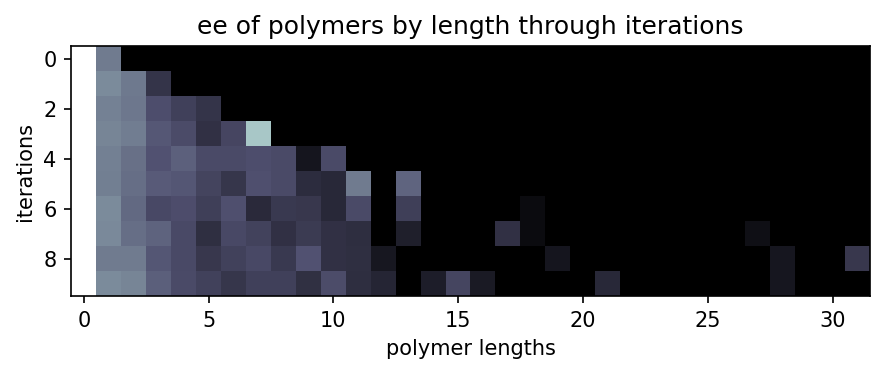

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

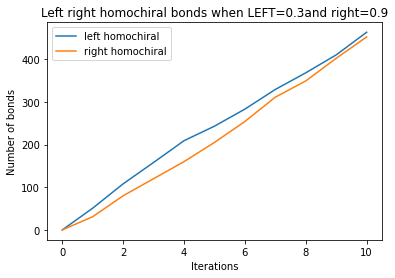

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

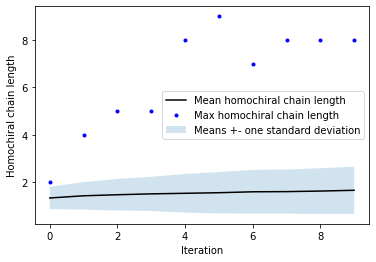

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

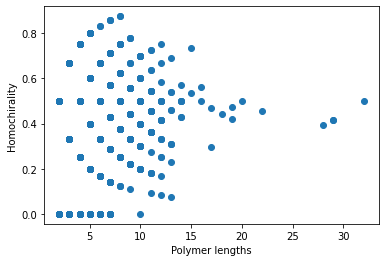

<IPython.core.display.Javascript object>

In [49]:
POOL_SIZE = 1000
ITERATIONS = 10


a = Reactables(make_pool(POOL_SIZE))

print("Running.............|\n", end="")

monomercounts = []

for n in range(ITERATIONS):
  a.iterate(POOL_SIZE)
  monomercounts.append(len(a.get_free_monomers())+len(a.get_bound_monomers()))
  if n % (ITERATIONS / 10) == 0:
    print("##",end="")

print("\nDone.")

a.parse_history()

stats = a.get_stats()

plots = ["parameters","polymer ee spread","polyspread plotly","ee heatmap","leftright chirality",
         "homochiral chain lengths", "homochirality vs length"]
tb = widgets.TabBar(plots)

with tb.output_to("parameters"):
  a.visualize_parameters()

with tb.output_to("polymer ee spread"):
  a.plot_signed_ee_spread()

with tb.output_to("polyspread plotly"):
  df = stats
  fig = px.scatter(df, x="Iteration", y="Signed ee", hover_data=["Sequence"])
  fig.show()

with tb.output_to("ee heatmap"):
  a.plot_ee_heatmap()

with tb.output_to("leftright chirality"):
  a.plot_leftrighthomochirality()

with tb.output_to("homochiral chain lengths"):
  a.plot_homochiral_chain_lengths()

with tb.output_to("homochirality vs length"):
  a.plot_homochirality_vs_length()




# a spot for checking code things

# Observations

Under the current refill rules, the upper bound for the total number of monomers (both free and within polymers) in the world is $1/2(P)(I)$ for $P$ = pool size and $I$ = number of iterations.

The upper bound on possible polymer size is 

$
\begin{equation}
  bound=\left\{
  \begin{array}{@{}ll@{}}
    2^n, & n \leq\ T \\
    2^T+(n-T)(2^{T-1}), & n>T
  \end{array}\right.
\end{equation} 
$

for $T=log_2(P)$.

For $P < 100$ or so, these bounds are substantially lower than $2^n$, but for large $P$ it matters less.

Also $2^T+(n-T)(2^{T-1}) = P(1+1/2(n-log_2(P))$ I think.